<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Introduction to Bootstrapping

---

## Learning Objectives

### Core
- Understand the concept of the non-parametric bootstrap
- Code the nonparametric bootstrap by hand
- Apply the nonparametric bootstrap to calculate confidence intervals for statistics

### Target
- Understand when the bootstrap is useful
- Practice performing the bootstrap

### Stretch
- Use the bootstrap to determine confidence intervals for correlation and regression coefficients

### Lesson Guide
- [The bootstrapping procedure](#bootstrapping)
- [Coding the nonparametric bootstrap](#code-bootstrap)
- [Comparing bootstrapped confidence intervals to standard](#compare-to-classic)
- [Bootstrapping the median](#bootstrap-median)
- [Theory behind the bootstrap](#theory)
- [Independent practice: confidence intervals of correlations](#independent-practice)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='bootstrapping'></a>

## The bootstrapping procedure

---

Bootstrapping is a powerful resampling method that allows us to estimate the degree of our uncertainty about practically any statistic. The beauty of bootstrapping is that this is done directly from the data without needing to make any assumptions about the distribution of our statistic!

There are many variations on the bootstrap. In this lesson we will cover only the classic **nonparametric bootstrap**. 

#### Bootstrapping the confidence interval of a statistic.

Say we wanted to calculate the 95% confidence interval around a statistic such as our sample mean. We could do this using the formula derived based on the Central Limit Theorem (CLT), selecting z-scores along the standard Normal distribution that corresponds to our confidence level and multiplying them by our standard error.

The nonparametric bootstrap procedure on the other hand does not rely on distributional assumptions of the parameter. Below is pseudocode describing the process:

---

```
for specified number of bootstrap iterations

    create a bootstrap sample by randomly selecting observations with
    replacement from your sample 
    (same size as sample)
    calculate the statistic of interest on bootstrap sample

calculate lower and upper percentile bounds of bootstrap statistics according to threshold
```

---

Where the 95% confidence threshold in our case would mean we calculate be 2.5th and 97.5th percentile of the bootstrapped sample means.

<a id='code-bootstrap'></a>

### Coding the nonparametric bootstrap by hand: starcraft data

---

Below we will code the nonparametric bootstrap function and calculate the confidence interval for the mean APM (Actions per Minute) from a sample of Starcraft data. 

**Load the Starcraft data:**

In [2]:
starcraft = './datasets/Starcraft_sample.csv'

In [3]:
star = pd.read_csv(starcraft)
print(star.shape)
star.head()

(200, 20)


,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,2307,5,22.0,42,2800,190.7448,0.009310,0.000495,4,0.000000,0.000307,0.004519,41.6515,53.1774,6.0189,26,0.002319,7,0.000000,0.000017
1,9213,5,34.0,4,364,77.5512,0.002448,0.000486,7,0.000178,0.000340,0.002496,31.8431,65.8701,4.9740,22,0.000713,6,0.000000,0.000000
2,209,3,20.0,6,150,72.1410,0.001238,0.000394,5,0.000019,0.000272,0.003376,45.9164,68.8778,3.7528,24,0.000797,8,0.000122,0.000356
3,2958,3,16.0,6,200,91.3188,0.000897,0.000130,5,0.000026,0.000663,0.002664,34.5490,74.6732,6.3512,27,0.001287,7,0.000195,0.000273
4,5533,4,22.0,20,800,85.3884,0.001188,0.000381,3,0.000067,0.000179,0.002980,26.9697,58.0752,5.0827,15,0.001098,4,0.000000,0.000157


**Extract the APM vector from the dataset:**

In [4]:
apm = star.APM

**Plot the distribution of APM with a histogram:**

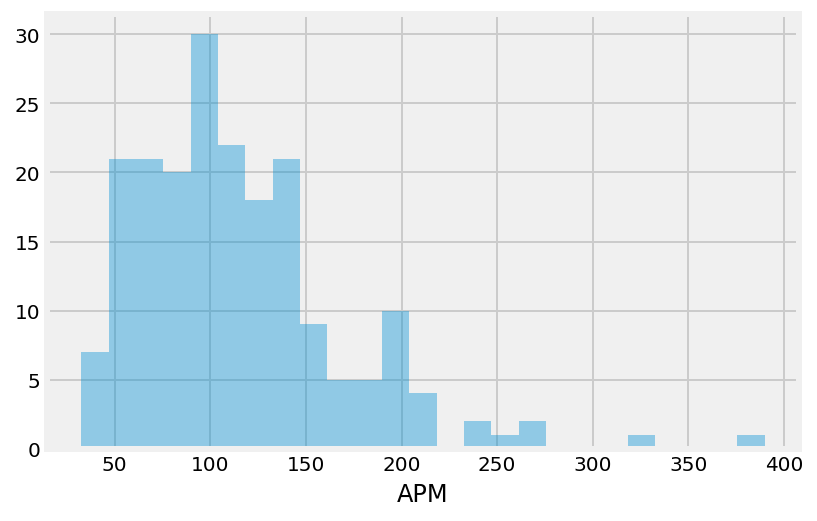

In [5]:
ax = sns.distplot(apm, bins=25, kde=False)

**Let's write a function for the nonparametric bootstrap procedure.**

The function will take three arguments:
- The sample
- The function to calculate the statistic of interest
- The number of iterations

The function should return a vector of the "bootstrapped" statistics. Refer to the pseudocode above. Remember that the random sampling must be done **with replacement** and the random sample must be the same size as the original sample.

In [6]:
def bootstrap(sample, stat_func, iterations=1000):
    """
    Create booststrapped sample from a given sample and calculate 
    at each iteration a statistic of the bootstrapped sample
    
    Sample: sample of observations, 
    stat_func: a statistical function
    iterations: number of bootstrap iterations
    
    Returns a list with the statistic evaluated for each bootstrapped sample 
    """
    
    boots = []
    
    for i in range(iterations):
        # Take a random choice from the given sample with replacement
        random_sample = np.random.choice(sample, replace=True, size=len(sample))
        # Calculate the statistic of the random sample
        stat = stat_func(random_sample)
        # append the statistic to the result list
        boots.append(stat)
        
    return boots

**Using our bootstrapping function with 1000 iterations let's calculate the 95% confidence interval for the mean APM.**

Remember that for a 95% confidence interval, we want to find the 2.5th percentile bootstrapped mean and the 97.5th percentile bootstrapped mean (corresponding to a threshold of 0.05).

The [`scipy.stats.scoreatpercentile`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.scoreatpercentile.html) function is useful for finding the values at these percentiles.

In [7]:
apm_boot = bootstrap(apm, np.mean)

apm_lower = stats.scoreatpercentile(apm_boot, 2.5)
apm_upper = stats.scoreatpercentile(apm_boot, 97.5)

print(apm_lower, np.mean(apm_boot), apm_upper)

107.42892075000002 114.38282598299999 121.76639992499999


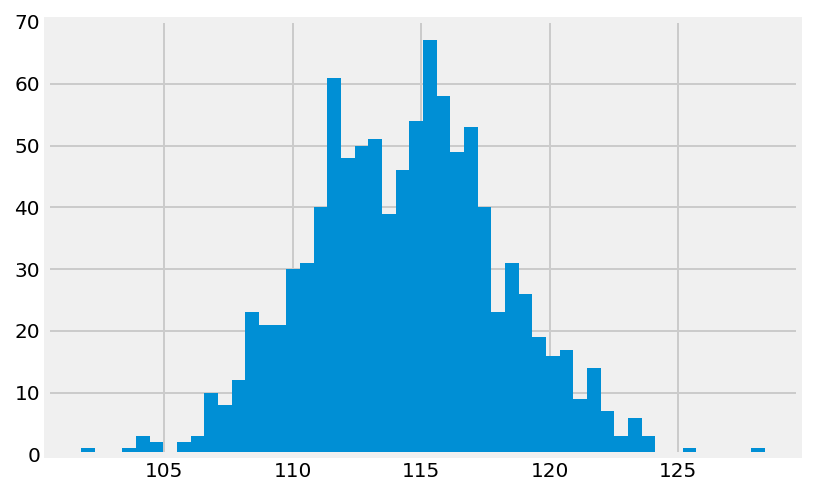

In [8]:
plt.hist(apm_boot,bins=50);

<a id='compare-to-classic'></a>

### Comparing the bootstrapped confidence interval to the classic formula

---

The classic formula for calculating the confidence interval bounds for the sample mean is:

$$ [\; \bar{x} + z_{\alpha/2}\frac{s}{\sqrt{n}},\; \bar{x} + z_{1-\alpha/2} \frac{s}{\sqrt{n}} ]$$

Where in our case $\alpha = 0.05$. Filling in the appropriate z-scores according to this threshold we have:

$$ [\; \bar{x} -1.96 \frac{s}{\sqrt{n}},\; \bar{x} + 1.96 \frac{s}{\sqrt{n}} ]$$

**Calculate the confidence interval for the mean APM with the formula above and compare it to our bootstrapped confidence interval.**

In [9]:
stats.norm().ppf(0.975)

1.959963984540054

In [10]:
std = np.std(apm)
sqrtn = np.sqrt(len(apm))

apm_lower = np.mean(apm) - stats.norm().ppf(0.025)*(std/sqrtn)
apm_upper = np.mean(apm) + stats.norm().ppf(0.975)*(std/sqrtn)

print(apm_lower, np.mean(apm), apm_upper)

121.74472095753352 114.323439 121.74472095753352


<a id='bootstrap-median'></a>

### A more practical example: bootstrapping the median

---

In the case of estimating the confidence around the sample mean, the bootstrapping procedure is not particularly useful since the sample mean has such nice distributional properties. 

The bootstrap becomes much more useful when we need to calculate our uncertainty around statistics without straightforward formulas or ones with unreasonably strict assumptions. The median is one such statistic. 

**Formula for the sample error of the median (to use for calculating confidence interval around the median):**

There is in fact a formula for the sample error of the median:

$$ \text{s.e. median} = 1.2533 \cdot \text{s.e. mean} $$

Which is a function of the sample error of the mean and uses a heuristic multiplier 1.2533. Furthermore, it requires these assumptions to work:

1. $N$ is large
2. The sample of measurements are drawn from a normally distributed population

**Check:** What about these assumptions is impractical?

---

The second assumption is strict – many distributions are not normally distributed. Furthermore, what tangible benefit do we get from calculating the median over the mean if we know ahead of time that the population is normally distributed?

The median is much more useful when we suspect a non-normally distributed population.


**Plot the distribution of APM from the Starcraft data with a vertical line indicating the median.**

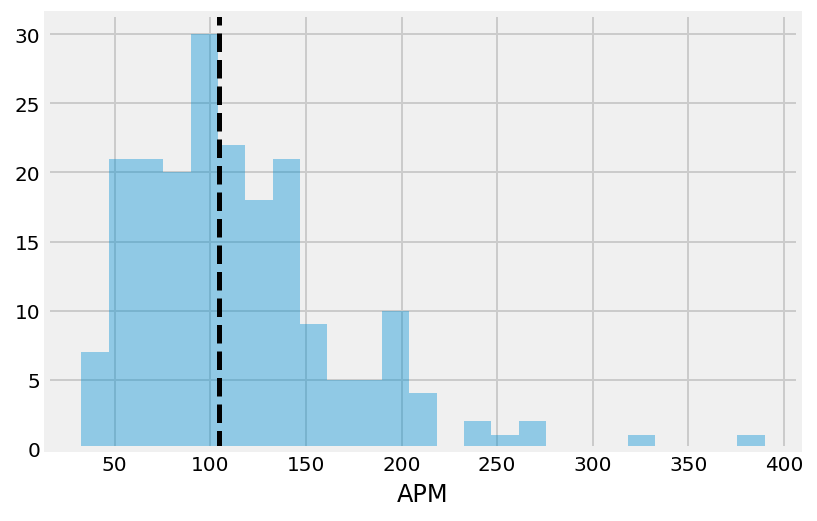

In [11]:
apm_median = np.median(apm)
ax = sns.distplot(apm, bins=25, kde=False)
ax.axvline(apm_median, lw=2.5, ls='dashed', color='black');

#### Calculate a 99% confidence interval for the median with the formula above.

The associated z-score magnitude is 2.576

In [12]:
stats.norm().ppf(0.995)

2.5758293035489004

In [13]:
se_mean = np.std(apm)/np.sqrt(len(apm))
se_median = se_mean*1.2533

apm_med_lower = np.median(apm) + stats.norm().ppf(0.005)*se_median
apm_med_upper = np.median(apm) + stats.norm().ppf(0.995)*se_median

print(apm_med_lower, np.median(apm), apm_med_upper)

92.16849218578044 104.3922 116.61590781421957


**Bootstrap the 99% confidence interval for the median with 1000 iterations.**

In [14]:
med_boot = bootstrap(apm, np.median)

med_boot_lower = stats.scoreatpercentile(med_boot, 0.5)
med_boot_median = stats.scoreatpercentile(med_boot, 50)
med_boot_upper = stats.scoreatpercentile(med_boot, 99.5)
med_boot_mean = np.mean(med_boot)

print(med_boot_mean)
print(med_boot_lower, med_boot_median, med_boot_upper)

104.3905053
96.435252 104.3922 116.628024


**How is the distribution different using the boostrap?**

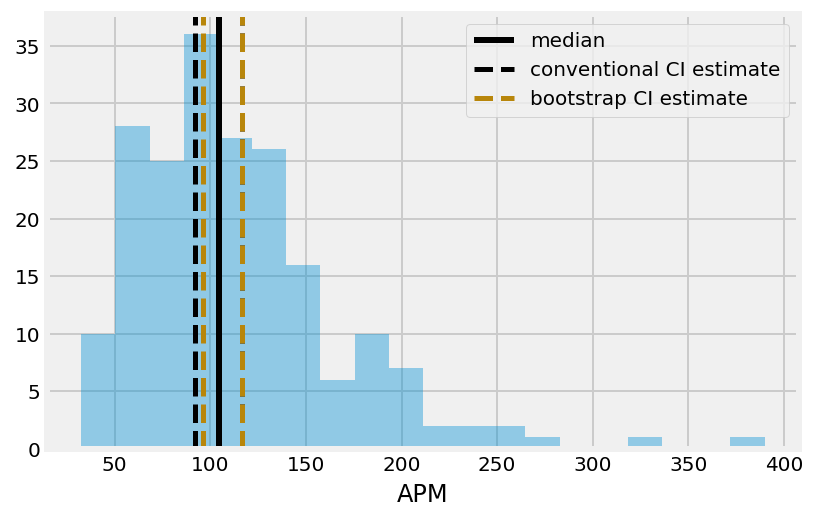

In [15]:
ax = sns.distplot(apm, bins=20, kde=False)
ax.axvline(np.median(apm), lw=3, color='black',label='median')
ax.axvline(apm_med_lower, lw=2.5, color='black', ls='dashed')
ax.axvline(apm_med_upper, lw=2.5, color='black', ls='dashed', label='conventional CI estimate')
ax.axvline(med_boot_lower, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.axvline(med_boot_upper, lw=2.5, color='darkgoldenrod', ls='dashed', label='bootstrap CI estimate' )
plt.legend()
plt.show()

<a id='theory'></a>

### Theory behind the bootstrap

---

The idea grounding the bootstrap is that inferences we can draw from random samples drawn from our sample can in turn be applied to our inference about the overall population. This is because our random sample of the sample mirrors the fact that our sample is randomly drawn from the population. 

Essentially, bootstrap samples are to our original sample as our original sample is to the overall population.

With a population parameter $\theta$ and sample statistic $\hat{\theta}$ we make an inference about the uncertainty around our estimate of the population parameter.

> We infer the population $\theta$ and uncertainty of the inference from sample $\hat{\theta}_{s}$.

With bootstrapping we mirror this process *to make an inference about the uncertainty around our "estimate" of the sample statistic.*

> Infer uncertainty of our sample statistic $\hat{\theta}_{s}$ from multiple random bootstrap samples drawn from the sample.



<a id='independent-practice'></a>

### Independent practice: bootstrapping the confidence interval of the correlation coefficient

---

Like the median, computing the confidence interval for the pearson correlation coefficient is not straightforward without using the bootstrap procedure. 

#### Using the starcraft data, calculate the correlation between two variables you are interested in and then compute the 95% and 99% confidence interval of the correlation with the bootstrap.

In [16]:
# A:

#### Using the Starcraft data, calculate a simple linear regression between two variables you are interested in and then compute the 95% and 99% confidence interval of the beta coefficients and the R2 score.

In [17]:
# A: